## Improving Dataset
References
* https://github.com/aleju/imgaug
* http://blog.yhat.com/posts/image-processing-with-scikit-image.html
* http://scikit-image.org/docs/dev/user_guide/transforming_image_data.html
* https://bradmontgomery.net/blog/pythons-zip-map-and-lambda/
* http://stackoverflow.com/questions/3204245/how-do-i-convert-a-tuple-of-tuples-to-a-one-dimensional-list-using-list-comprehe
* https://github.com/sahiljuneja/Udacity-SDCND-Term-1/tree/master/P3-Behavioral-Cloning
* https://github.com/CYHSM/carnd
* https://github.com/udacity/self-driving-car
* https://github.com/udacity/self-driving-car/tree/master/steering-models/community-models/rambo
* http://stackoverflow.com/questions/40062770/adding-data-to-existing-h5py-file-along-new-axis-using-h5py

In [1]:
import numpy as np
from driving_data import HandleData
import matplotlib.pyplot as plt
import os
import subprocess
import glob
import lmdb
from augment_batch import AugmentDrivingBatch
import random

import skimage
import skimage.filters
import skimage.color

LMDB_PATH = 'Dataset_Test_LMDB'
LMDB_PATH_DEST = 'Dataset_Test_LMDB_DEST'

In [2]:
lst_labels_read = []
lst_imgs_read = []
env = lmdb.open(LMDB_PATH, readonly=True)
with env.begin() as txn:
    cursor = txn.cursor()
    for key, value in cursor:                
        key_str = key.decode('ascii')
        #print(key_str)
        if 'label' in key_str:            
            lst_labels_read.append(np.float32(np.asscalar(np.frombuffer(value, dtype=np.float32, count=1))))
        else:            
            # Get shape information from key name
            info_key = key_str.split('_')
            # Get image shape [2:None] means from index 2 to the end
            shape_img = tuple(map(lambda x:int(x) ,info_key[2:None]))            
            # Convert to float32
            lst_imgs_read.append(np.frombuffer(value, dtype=np.uint8).reshape(shape_img))  

### Get histogram of inputs
Observe from the histogram that almost all the actions are angle=0 on the steering wheel, the problem is that if we backpropagate this the network will find fine output always angle=0

Dataset size: 1480


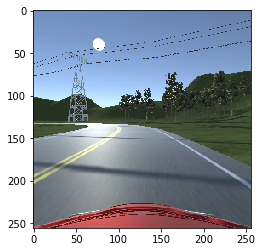

Wheel angle: -0.0413943


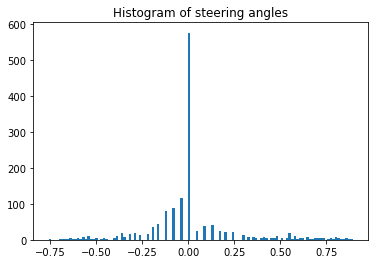

[-0.75792789 -0.59278628 -0.42764466 -0.26250304 -0.09736142  0.0677802
  0.23292181  0.39806343  0.56320505  0.72834667  0.89348829]


In [10]:
print('Dataset size:', len(lst_imgs_read))
rand_index = random.randint(0,len(lst_imgs_read)-1)
plt.imshow(lst_imgs_read[rand_index].astype(np.uint8))
plt.show()
print('Wheel angle:', lst_labels_read[rand_index])
plt.hist(lst_labels_read,bins='auto')
plt.title("Histogram of steering angles")
plt.show()
hist, bin_edges = np.histogram(lst_labels_read, density=True)
print(bin_edges)

### Select images from dataset where steering angle is 0,Left,Right

In [4]:
# Create a list with images and angles
list_img_angles = list(zip(lst_imgs_read, lst_labels_read))

# Select the items of the zip list where the angle is 0, left or right
list_img_angles_zeros = [(img,steering) for (img,steering) in list_img_angles if steering == 0]
list_img_angles_left = [(img,steering) for (img,steering) in list_img_angles if steering < 0]
list_img_angles_right = [(img,steering) for (img,steering) in list_img_angles if steering > 0]

# Display quantity
print('Number (angles==0)=%d'% len(list_img_angles_zeros))
print('Number (angles==Left)=%d'% len(list_img_angles_left))
print('Number (angles==Right)=%d'% len(list_img_angles_right))

Number (angles==0)=577
Number (angles==Left)=535
Number (angles==Right)=368


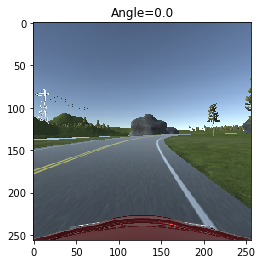

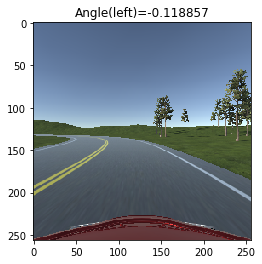

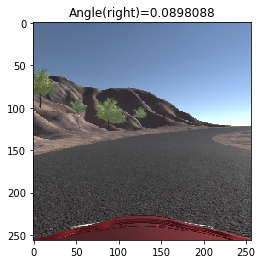

In [5]:
# Angle 0 example
[img,steering] = list_img_angles_zeros[random.randint(0,len(list_img_angles_zeros)-1)]
plt.imshow(img)
plt.title('Angle=' + str(steering))
plt.show()

# Angle (left) example
[img,steering] = list_img_angles_left[random.randint(0,len(list_img_angles_left)-1)]
plt.imshow(img)
plt.title('Angle(left)=' + str(steering))
plt.show()

# Angle (right) example
[img,steering] = list_img_angles_right[random.randint(0,len(list_img_angles_right)-1)]
plt.imshow(img)
plt.title('Angle(right)=' + str(steering))
plt.show()

## Define function to generate videos from matplotlib (depends on ffmpeg)

In [ ]:
def generate_video(list_img_angle):
    folder = os.getcwd()
    
    # Create folder if does not exist
    if not os.path.exists(folder + '/imgsVideo'):
        os.makedirs(folder + '/imgsVideo')
    
    cntFile = 0
    for img,angle in list_img_angle:
        plt.imshow(img)
        plt.title('Angle=' + str(angle))
        plt.savefig(folder + "/imgsVideo/file%02d.png" % cntFile)
        cntFile += 1

    os.chdir(folder + '/imgsVideo')
    subprocess.call([
        'ffmpeg', '-framerate', '8', '-i', 'file%02d.png', '-r', '30', '-pix_fmt', 'yuv420p',
        'video_name.mp4'
    ])
    
    # Delete 
    for file_name in glob.glob("*.png"):
        os.remove(file_name)
    
    # Go back to previous directory
    os.chdir(folder)

# Generate videos for angle=0    
generate_video(list_img_angles_zeros)    

## Balance dataset

In [6]:
# Get zeros list
list_img_angles_zeros = [(img,steering) for (img,steering) in list_img_angles if steering == 0]
size_zeros = len(list_img_angles_zeros)

# Get list and number of samples that are not 0
#list_img_angles_not_zeros = [(img,steering) for (img,steering) in list_img_angles if steering > 0.1 or steering < -0.1]
list_img_angles_not_zeros = [(img,steering) for (img,steering) in list_img_angles if steering != 0]
size_not_zeros = len(list_img_angles_not_zeros)
print("Size not zeros: %d" % size_not_zeros)
print("Size zeros: %d" % size_zeros)

Size not zeros: 903
Size zeros: 577


In [7]:
list_img_angles_balanced = list_img_angles
print(len(list_img_angles_balanced))
# Ignore some zeros (Bad idea probably because it's trowing data away)
#sub_zero = list_img_angles_zeros[0:150]
#print(len(sub_zero))
list_img_angles_balanced.extend(list_img_angles_not_zeros)
list_img_angles_balanced.extend(list_img_angles_not_zeros)
list_img_angles_balanced.extend(list_img_angles_not_zeros)
list_img_angles_balanced.extend(list_img_angles_not_zeros)
list_img_angles_balanced.extend(list_img_angles_not_zeros)
list_img_angles_balanced.extend(list_img_angles_not_zeros)
list_img_angles_balanced.extend(list_img_angles_not_zeros)
list_img_angles_balanced.extend(list_img_angles_not_zeros)
list_img_angles_balanced.extend(list_img_angles_not_zeros)
list_img_angles_balanced.extend(list_img_angles_not_zeros)
print(len(list_img_angles_balanced))

1480
10510


<class 'list'>


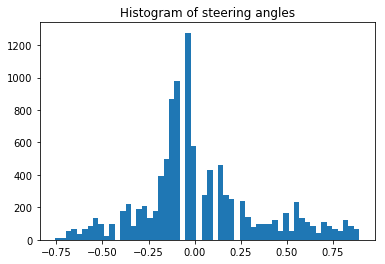

In [8]:
ys_balanced = []
for (tup_element) in list_img_angles_balanced:
    _,steer = tup_element
    ys_balanced.append(steer)


#ys_balanced = [(_,steer) for (tup_element) in list_img_angles_balanced]
print(type(ys_balanced))

plt.hist(np.array(ys_balanced),bins='auto')
plt.title("Histogram of steering angles")
plt.show()

### Save Balanced dataset to hdf5

In [ ]:
data.save_hdf5(list_img_angles_balanced)